# Business Problem

An e-commerce company wants to segment its customers and determine marketing strategies according to these segments.

For this, we will define the behavior of customers and create groups according to the clusters in these behaviors.

In other words, we will take those who exhibit common behaviors into the same groups and we will try to develop sales and marketing specific techniques to these groups.

In [37]:
#installation of libraries
import pandas as pd
import numpy as np
import seaborn as sns

#to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);

#we determined how many numbers to show after comma
pd.set_option('display.float_format', lambda x: '%.0f' % x)
import matplotlib.pyplot as plt

In [38]:
#calling the dataset
df = pd.read_csv("data/online_retail_II.csv")

# Data Understanding

In [39]:
#selection of the first 5 observations
df.head() 

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1,13085,United Kingdom


In [40]:
#ranking of the most ordered products
df.groupby("Description").agg({"Quantity":"sum"}).sort_values("Quantity", ascending = False).head()

,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,108545
WHITE HANGING HEART T-LIGHT HOLDER,93050
ASSORTED COLOUR BIRD ORNAMENT,81306
JUMBO BAG RED RETROSPOT,78090
BROCADE RING PURSE,70700


In [41]:
#how many invoices are there in the data set
df["Invoice"].nunique()

53628

In [42]:
#which are the most expensive products?
df.sort_values("Price", ascending = False).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
748142,C556445,M,Manual,-1,2011-06-10 15:31:00,38970,15098,United Kingdom
241827,512771,M,Manual,1,2010-06-17 16:53:00,25111,NaN,United Kingdom
241824,C512770,M,Manual,-1,2010-06-17 16:52:00,25111,17399,United Kingdom
320581,C520667,BANK CHARGES,Bank Charges,-1,2010-08-27 13:42:00,18911,NaN,United Kingdom
1050063,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:36:00,17836,NaN,United Kingdom


In [43]:
#top 5 countries with the highest number of orders
df["Country"].value_counts().head()

United Kingdom    981330
EIRE               17866
Germany            17624
France             14330
Netherlands         5140
Name: Country, dtype: int64

In [44]:
#total spending was added as a column
df['TotalPrice'] = df['Price']*df['Quantity']

In [45]:
#which countries did we get the most income from
df.groupby("Country").agg({"TotalPrice":"sum"}).sort_values("TotalPrice", ascending = False).head()

,TotalPrice
Country,
United Kingdom,16382584
EIRE,615520
Netherlands,548525
Germany,417989
France,328192


# Data Preparation

In [46]:
df["InvoiceDate"].min() #oldest shopping date

'2009-12-01 07:45:00'

In [47]:
df["InvoiceDate"].max() #newest shopping date

'2011-12-09 12:50:00'

In [48]:
#to make the assessment easier, today's date is set as January 1, 2012.  
today = pd.datetime(2012,1,1) 
today

<ipython-input-48-581e166d8028>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = pd.datetime(2012,1,1)


datetime.datetime(2012, 1, 1, 0, 0)

In [49]:
#changing the data type of the order date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [50]:
#taking values greater than 0, this will be easier in terms of evaluation
df = df[df['Quantity'] > 0]
df = df[df['TotalPrice'] > 0]

In [51]:
df.dropna(inplace = True) #removal of observation units with missing data from df

In [52]:
df.shape #size information

(805549, 9)

In [53]:
df.describe([0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95, 0.99]).T
#explanatory statistics values of the observation units corresponding to the specified percentages
#processing according to numerical variables

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
Quantity,805549,13,144,1,1,1,1,2,5,12,24,36,128,80995
Price,805549,3,29,0,0,0,1,1,2,4,7,8,15,10954
Customer ID,805549,15332,1697,12346,12422,12681,12979,13982,15271,16805,17716,17913,18204,18287
TotalPrice,805549,22,224,0,1,1,2,5,12,20,35,68,202,168470


# Finding RFM Score

RFM consists of Recency, Frequency, Monetary initials of expressions.

It is a technique that helps determine marketing and sales strategies based on buying habits of customers.

- Recency: Time since customer last purchase

- Frequency: Total number of purchases.

- Monetary: Total spending by the customer.


In [54]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,83
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,81
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,7,13085,United Kingdom,81
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2,13085,United Kingdom,101
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1,13085,United Kingdom,30


In [55]:
df.info() 
#dataframe's index dtype and column dtypes, non-null values and memory usage information

<class 'pandas.core.frame.DataFrame'>
Int64Index: 805549 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805549 non-null  object        
 1   StockCode    805549 non-null  object        
 2   Description  805549 non-null  object        
 3   Quantity     805549 non-null  int64         
 4   InvoiceDate  805549 non-null  datetime64[ns]
 5   Price        805549 non-null  float64       
 6   Customer ID  805549 non-null  float64       
 7   Country      805549 non-null  object        
 8   TotalPrice   805549 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 61.5+ MB


In [56]:
# finding Recency and Monetary values.
df_x = df.groupby('Customer ID').agg({'TotalPrice': lambda x: x.sum(), #monetary value
                                        'InvoiceDate': lambda x: (today - x.max()).days}) #recency value
#x.max()).days; last shopping date of customers

In [57]:
df_y = df.groupby(['Customer ID','Invoice']).agg({'TotalPrice': lambda x: x.sum()})
df_z = df_y.groupby('Customer ID').agg({'TotalPrice': lambda x: len(x)}) 
#finding the frequency value per capita

In [58]:
#creating the RFM table
rfm_table= pd.merge(df_x,df_z, on='Customer ID')

In [59]:
#determination of column names
rfm_table.rename(columns= {'InvoiceDate': 'Recency',
                          'TotalPrice_y': 'Frequency',
                          'TotalPrice_x': 'Monetary'}, inplace= True)

In [60]:
rfm_table.head()

,Monetary,Recency,Frequency
Customer ID,,,
12346,77556,347,12
12347,5633,24,8
12348,2019,97,5
12349,4429,40,4
12350,334,332,1


**Table Comment**: The customer with the 12346th Customer ID made a purchase of £ 77.556. The last purchase of this customer is about 1 year ago (347 days) and the number of purchases is 12.

In [61]:
#RFM score values 
rfm_table['RecencyScore'] = pd.qcut(rfm_table['Recency'],5,labels=[5,4,3,2,1])
rfm_table['FrequencyScore'] = pd.qcut(rfm_table['Frequency'].rank(method="first"),5,labels=[1,2,3,4,5])
rfm_table['MonetaryScore'] = pd.qcut(rfm_table['Monetary'],5,labels=[1,2,3,4,5])

In [62]:
rfm_table.head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore
Customer ID,,,,,,
12346,77556,347,12,2,5,5
12347,5633,24,8,5,4,5
12348,2019,97,5,3,4,4
12349,4429,40,4,5,3,5
12350,334,332,1,2,1,2


In [63]:
#RFM score values are combined side by side in str format
(rfm_table['RecencyScore'].astype(str) + 
 rfm_table['FrequencyScore'].astype(str) + 
 rfm_table['MonetaryScore'].astype(str)).head()

Customer ID
12346    255
12347    545
12348    344
12349    535
12350    212
dtype: object

In [64]:
#calculation of the RFM score
rfm_table["RFM_SCORE"] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str) + rfm_table['MonetaryScore'].astype(str)

In [65]:
rfm_table.head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
Customer ID,,,,,,,
12346,77556,347,12,2,5,5,255
12347,5633,24,8,5,4,5,545
12348,2019,97,5,3,4,4,344
12349,4429,40,4,5,3,5,535
12350,334,332,1,2,1,2,212


In [66]:
#transposition of the RFM table. This makes it easier to evaluate.
rfm_table.describe().T

,count,mean,std,min,25%,50%,75%,max
Monetary,5878,3019,14738,3,349,899,2307,608822
Recency,5878,223,209,22,47,117,401,760
Frequency,5878,6,13,1,1,3,7,398


In [67]:
#customers with RFM Score 555
rfm_table[rfm_table["RFM_SCORE"] == "555"].head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
Customer ID,,,,,,,
12362,5356,25,11,5,5,5,555
12395,5067,41,15,5,5,5,555
12417,6817,25,20,5,5,5,555
12433,20581,22,10,5,5,5,555
12437,12683,23,39,5,5,5,555


In [68]:
#customers with RFM Score 111
rfm_table[rfm_table["RFM_SCORE"] == "111"].head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE
Customer ID,,,,,,,
12387,144,437,1,1,1,1,111
12392,235,613,1,1,1,1,111
12400,205,436,1,1,1,1,111
12404,63,704,1,1,1,1,111
12416,203,678,1,1,1,1,111


In [69]:
#segmenting of customers according to RecencyScore and FrequencyScore values
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

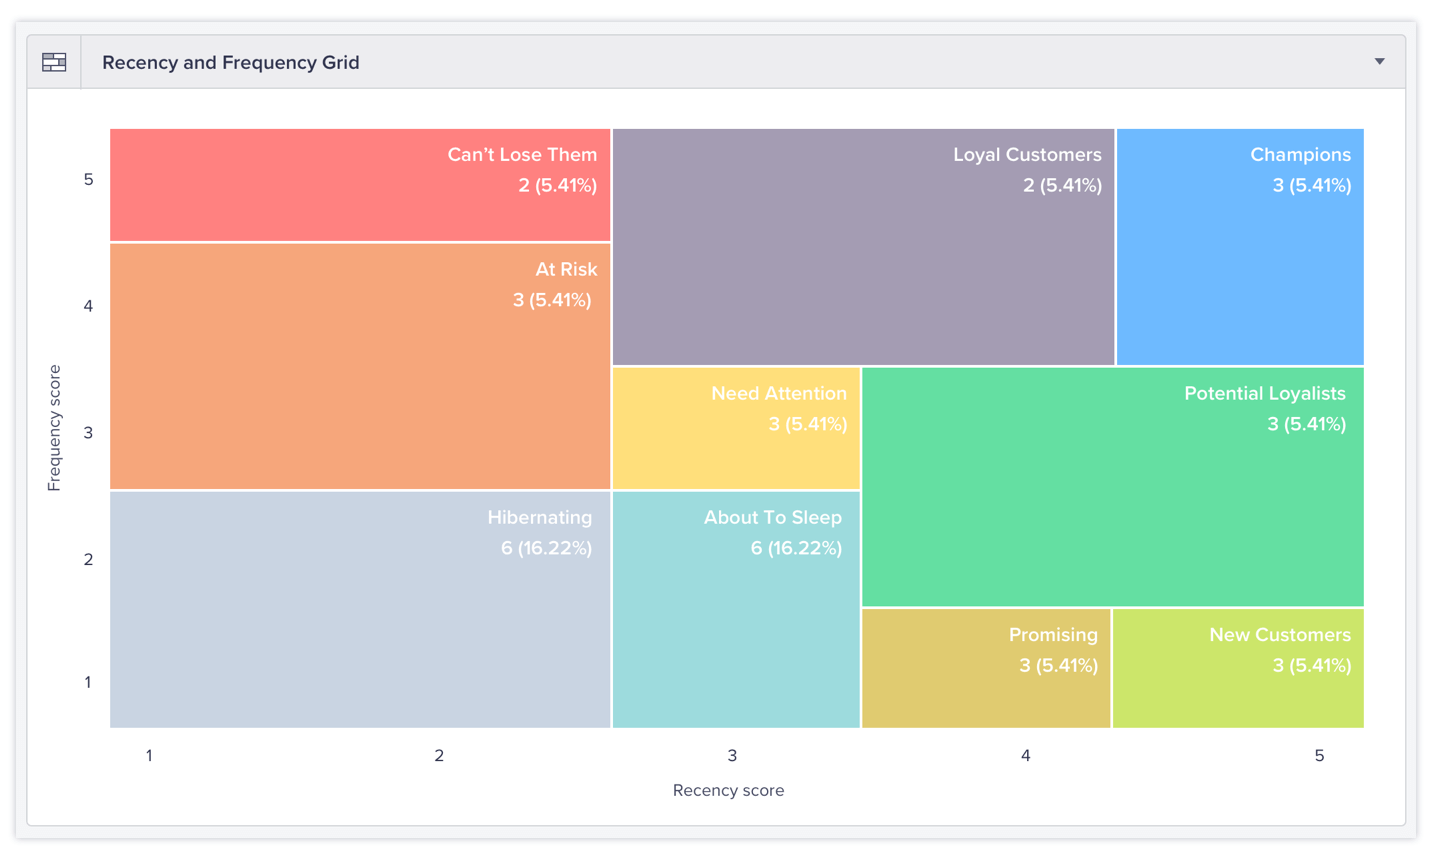

In [70]:
#creation of segment variable
rfm_table['Segment'] = rfm_table['RecencyScore'].astype(str) + rfm_table['FrequencyScore'].astype(str)
rfm_table['Segment'] = rfm_table['Segment'].replace(seg_map, regex=True)

With "regex = True", we used the names like "need attention", "can't lose" instead of RFM scores to the data set.

In [71]:
rfm_table.head()

,Monetary,Recency,Frequency,RecencyScore,FrequencyScore,MonetaryScore,RFM_SCORE,Segment
Customer ID,,,,,,,,
12346,77556,347,12,2,5,5,255,Can't Lose
12347,5633,24,8,5,4,5,545,Champions
12348,2019,97,5,3,4,4,344,Loyal Customers
12349,4429,40,4,5,3,5,535,Potential Loyalists
12350,334,332,1,2,1,2,212,Hibernating


In [72]:
rfm_table[["Segment", "Recency","Frequency","Monetary"]].groupby("Segment").agg(["mean","count"])

Recency       Frequency       Monetary      
                       mean count      mean count     mean count
Segment                                                         
About to Sleep          129   388         1   388      532   388
At Risk                 395   750         4   750     1384   750
Can't Lose              353    71        16    71     8356    71
Champions                30   852        19   852    10796   852
Hibernating             481  1522         1  1522      438  1522
Loyal Customers          89  1147        10  1147     4200  1147
Need Attention          135   269         3   269     1283   269
New Customers            32    56         1    56      356    56
Potential Loyalists      47   713         3   713     1155   713
Promising                60   110         1   110      324   110

We grouped the rfm table according to the mean and count values of the segment variable.

## Remark: 

3 segments selected for evaluation are "Can't Lose", "Hibernating" and "Champions".

Number of customers for segments:

Can't Lose = 71, Hibernating = 1522, Champions = 852


- Can't Lose Segment;

    - The last shopping date of the customers is on average 353 days before.
    - Customers have made an average of 16 purchases.
    - Customers spent an average of £ 8356.


- Hibernating Segment;

    - The last shopping date of the customers is 481 days before average.
    - Customers made an average of 1 purchases.
    - Customers spent an average of £ 438.


- Champions Segment;

    - The last shopping date of the customers is 30 days before average.
    - Customers made an average of 19 purchases.
    - Customers spent an average of £ 10796.


- Can't Lose Segment;

    - Customers in this segment have not recently made a purchase. For this reason, we need to prepare a discount and gift campaign for this segment. These customers made a large number of purchases when they made purchases before. However, recency values are lower than they should be. The campaign to be implemented for these customers should include both items purchased and recommendations based on previous activities. New and popular products associated with the products that they were interested in can also be included in this campaign. Situations that will cause these customers to stop buying need to be investigated.


- Hibernating Segment;

    - Customers in this segment have not made a purchase for a long time. However, by offering discounts, they may be attracted to another purchase.


- Champions Segment;

    - Customers in this segment are responsible for most of the revenue. Campaigns should be implemented to ensure the continuity of the shopping of these customers.

Resources;
- https://docs.exponea.com/docs/rfm-segmentation

- Recency and Frequency Grid Image: https://clevertap.com/blog/automate-user-segmentation-with-rfm-analysis/